In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
import ipywidgets as widgets
%load_ext autoreload

In [13]:
%autoreload
import codebase
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *


categories = ['C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
              'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',
              'C7_Restrictions on internal movement', 'C8_International travel controls']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

def events(values, flag=None):
    events = []
    current_value = values[0]
    start = 0
    for i, value in enumerate(values):
        if value != current_value:
            if not flag is None:
                if flag[i-1] == 0:
                    fl = '///'
                else:
                    fl = None
            else:
                fl = None
            events.append((start, i - start, current_value, fl))
            current_value = value
            start = i
    
    
    if not flag is None:
        if flag[i-1] == 0:
            fl = '///'
        else:
            fl = None
    else:
        fl = None
    events.append((start, i - start, current_value, fl))
    return events
            
    
def plot_stringency(df, ax):
    import matplotlib.patches as mpatches
    circ1 = mpatches.Patch( facecolor='white' , hatch=r'///', label='Targeted measures')
    total_length = len(df.index)
    y_ticks = []
    for i, col in enumerate(categories):
        flag_col = col[:3] + 'Flag'
        if flag_col != 'C8_Flag':
            current_events = events(df[[col]].values.flatten(), df[[flag_col]].values.flatten())
        else:
            current_events = events(df[[col]].values.flatten())
        for event in current_events:
            ax.broken_barh([(event[0], event[1])], (10*i, 2*event[2]), facecolors=colors[i], hatch=event[3])
        y_ticks.append(i*10)
    ax.set_ylim(0, 10*(i+1))
    ax.set_xlim(0, total_length)
    ax.set_xlabel('days')
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([cat[3:] for cat in categories])
    ax.legend(handles = [circ1],loc=2)
    ax.grid(True)

dataset = CountryDataset()

## Raw stringency

In [3]:
stri_cols = ['C1_School closing', 'C2_Workplace closing', 
             'C3_Cancel public events',
             'C4_Restrictions on gatherings', 'C5_Close public transport', 'C6_Stay at home requirements',
             'C7_Restrictions on internal movement',
             'C8_International travel controls', 
             # 'C1_Flag', 'C2_Flag', 'C3_Flag', 'C4_Flag', 'C5_Flag', 'C6_Flag', 'C7_Flag'
            ]

cols = {'variables': ['ConfirmedCases'] + stri_cols,
        'time_dependent_variables': ['ConfirmedCases'] + stri_cols,
        'predicted_variables': ['ConfirmedCases'],
        'max_degree': 3}

In [44]:

def plot_measures(country):
    country_data = dataset.ox_for(country, rescaling=1)
    f, ax1 = plt.subplots()
    ax1.set_title(country)
    ax2 = ax1.twinx()
    plot_stringency(country_data, ax1)
    ax2.plot(list(country_data['ConfirmedCases']), 'k.')
    plt.show()
    
a = widgets.interact(plot_measures, country=dataset.all_ox_countries())

interactive(children=(Dropdown(description='country', options=(0, 'Aruba', 'Afghanistan', 'Angola', 'Albania',…

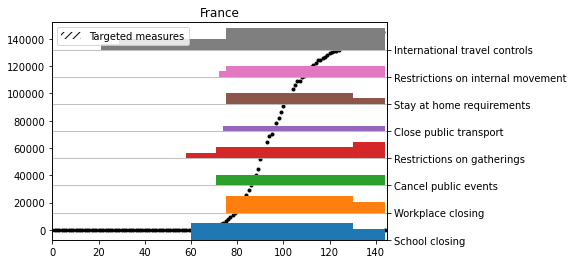

In [36]:
country = "France"
country_data = dataset.ox_for(country, rescaling=1)
f, ax1 = plt.subplots()
ax1.set_title(country)
ax1.plot(list(country_data['ConfirmedCases']), 'k.')
ax2 = ax1.twinx()
plot_stringency(country_data, ax2)
plt.show()

In [25]:
country = "Afghanistan"

m2, m1 = make_targets_df(dataset.ox_for(country, rescaling=(rescaling:=10000)))

augmented, integration_args = make_polynomials_df(m1, **cols)

weights, _ = sparse_regression(augmented, m2[cols['predicted_variables']].values, cutoff=5e-4)
# integration_args['weights'] = weights
# weights


100%|████████████| 50/50 [00:00<00:00, 203.96it/s]


[]

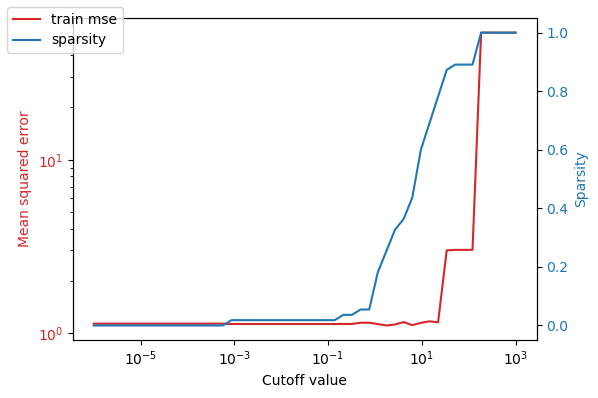

In [5]:
cutoffs = np.logspace(-6, 3, num=50)
sparsity = []
mses = []
all_weights = []

for k in tqdm(cutoffs, ncols=50):
    weights, _ = sparse_regression(augmented, m2[cols['predicted_variables']].values, cutoff=k)
    mse = ((tf.matmul(tf.cast(augmented, dtype=tf.float32), tf.cast(weights, dtype=tf.float32)) - m2[cols['predicted_variables']].values)**2).numpy().mean()
    mses.append(mse)
    sparsity.append((weights.numpy() == 0).sum()/len(weights.numpy().flatten()))
    all_weights.append(weights)

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(cutoffs, mses, color=color, label='train mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(cutoffs, sparsity, color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()
plt.plot()
# plt.savefig('sparsity_vs_mse.png', dpi=100)


In [6]:
candidates = [(e, i) for i, e in enumerate(dict(zip(mses, cutoffs)).items())]
    
    
extrapolation = 20
def select_weights(a):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(10, 8))
    country_data = m1
    t = range(len(country_data.index) + extrapolation)
    high_data = country_data[country_data['ConfirmedCases'] > 2]
    real_t = len(high_data.index)
    guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **cols, weights=all_weights[a])
    ax1.plot(t[:-extrapolation], country_data['ConfirmedCases'], 'k.', label='real data')
    ax1.plot(t[-real_t-extrapolation:], guess[:, 0], label='predictions')
    ax1.legend()
    ax1.set_title(country)
    plot_stringency(country_data, ax2)
    # plt.show()

_ = widgets.interact(select_weights, a=candidates)

interactive(children=(Dropdown(description='a', options=(((1.1334903, 0.0005689866029018299), 0), ((1.1281972,…

In [7]:
all_weights[-1]

<tf.Tensor: shape=(55, 1), dtype=float64, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])>

C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kipr\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\kipr\Documents\GitHub\files\internship\codebase\utils.py:251: RuntimeWarning: invalid value encountered in matmul
  predicted_values.append(current_filter @ constant_terms)


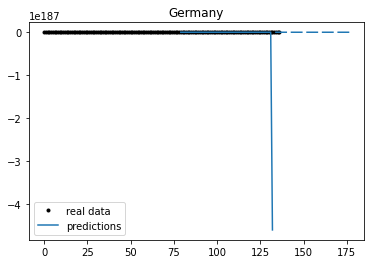

In [102]:
country_data = m1
t = range(len(country_data.index) + (extrapolation:=40))
high_data = country_data[country_data['ConfirmedCases'] > 0.1]
real_t = len(high_data.index)
guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **cols, weights=all_weights[0])
plt.plot(t[:-extrapolation], country_data['ConfirmedCases'], 'k.', label='real data')
plt.plot(t[-real_t-extrapolation:], guess[:, 0], label='predictions')
plt.legend()
plt.title(country)
plt.show()


In [11]:
all_weights[25]

<tf.Tensor: shape=(153, 1), dtype=float32, numpy=
array([[ 1.0097812 ],
       [-0.07646948],
       [ 0.        ],
       [ 0.03992122],
       [ 0.        ],
       [ 0.08587456],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.01275127],
       [ 0.        ],
       [ 0.        ],
       [ 0.06678031],
       [-3.07522   ],
       [ 0.29193038],
       [-0.05049528],
       [-0.10054695],
       [ 0.9974977 ],
       [ 0.        ],
       [ 1.9949954 ],
       [ 0.        ],
       [-0.15997513],
       [ 0.        ],
       [ 1.0526471 ],
       [ 0.        ],
       [-2.0452409 ],
       [ 0.        ],
       [ 0.06369219],
       [ 0.        ],
       [ 0.        ],
       [ 0.00593761],
       [-0.02104353],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.01224786],
       [ 0.        ],
    